<a href="https://colab.research.google.com/github/katshalonskaya/Project-for-AoSN/blob/main/Node2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install node2vec
!pip install graphistry

In [ ]:
!pip install hdbscan

In [ ]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape
    
def mask_test_edges(adj, test_frac=.1, val_frac=.05, prevent_disconnect=True, verbose=False):
    # NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.

    if verbose == True:
        print('preprocessing...')

    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()
    # Check that diag is zero:
    assert np.diag(adj.todense()).sum() == 0

    g = nx.from_scipy_sparse_matrix(adj)
    orig_num_cc = nx.number_connected_components(g)

    adj_triu = sp.triu(adj) # upper triangular portion of adj matrix
    adj_tuple = sparse_to_tuple(adj_triu) # (coords, values, shape), edges only 1 way
    edges = adj_tuple[0] # all edges, listed only once (not 2 ways)
    # edges_all = sparse_to_tuple(adj)[0] # ALL edges (includes both ways)
    num_test = int(np.floor(edges.shape[0] * test_frac)) # controls how large the test set should be
    num_val = int(np.floor(edges.shape[0] * val_frac)) # controls how alrge the validation set should be

    # Store edges in list of ordered tuples (node1, node2) where node1 < node2
    edge_tuples = [(min(edge[0], edge[1]), max(edge[0], edge[1])) for edge in edges]
    all_edge_tuples = set(edge_tuples)
    train_edges = set(edge_tuples) # initialize train_edges to have all edges
    test_edges = set()
    val_edges = set()

    if verbose == True:
        print('generating test/val sets...')

    # Iterate over shuffled edges, add to train/val sets
    np.random.shuffle(edge_tuples)
    for edge in edge_tuples:
        # print(edge)
        node1 = edge[0]
        node2 = edge[1]

        # If removing edge would disconnect a connected component, backtrack and move on
        g.remove_edge(node1, node2)
        if prevent_disconnect == True:
            if nx.number_connected_components(g) > orig_num_cc:
                g.add_edge(node1, node2)
                continue

        # Fill test_edges first
        if len(test_edges) < num_test:
            test_edges.add(edge)
            train_edges.remove(edge)

        # Then, fill val_edges
        elif len(val_edges) < num_val:
            val_edges.add(edge)
            train_edges.remove(edge)

        # Both edge lists full --> break loop
        elif len(test_edges) == num_test and len(val_edges) == num_val:
            break

    if (len(val_edges) < num_val or len(test_edges) < num_test):
        print("WARNING: not enough removable edges to perform full train-test split!")
        print("Num. (test, val) edges requested: (", num_test, ", ", num_val, ")")
        print("Num. (test, val) edges returned: (", len(test_edges), ", ", len(val_edges), ")")

    if prevent_disconnect == True:
        assert nx.number_connected_components(g) == orig_num_cc

    if verbose == True:
        print('creating false test edges...')

    test_edges_false = set()
    while len(test_edges_false) < num_test:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge not an actual edge, and not a repeat
        if false_edge in all_edge_tuples:
            continue
        if false_edge in test_edges_false:
            continue

        test_edges_false.add(false_edge)

    if verbose == True:
        print('creating false val edges...')

    val_edges_false = set()
    while len(val_edges_false) < num_val:
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false:
            continue
            
        val_edges_false.add(false_edge)

    if verbose == True:
        print('creating false train edges...')

    train_edges_false = set()
    while len(train_edges_false) < len(train_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue

        false_edge = (min(idx_i, idx_j), max(idx_i, idx_j))

        # Make sure false_edge in not an actual edge, not in test_edges_false, 
            # not in val_edges_false, not a repeat
        if false_edge in all_edge_tuples or \
            false_edge in test_edges_false or \
            false_edge in val_edges_false or \
            false_edge in train_edges_false:
            continue

        train_edges_false.add(false_edge)

    if verbose == True:
        print('final checks for disjointness...')

    # assert: false_edges are actually false (not in all_edge_tuples)
    assert test_edges_false.isdisjoint(all_edge_tuples)
    assert val_edges_false.isdisjoint(all_edge_tuples)
    assert train_edges_false.isdisjoint(all_edge_tuples)

    # assert: test, val, train false edges disjoint
    assert test_edges_false.isdisjoint(val_edges_false)
    assert test_edges_false.isdisjoint(train_edges_false)
    assert val_edges_false.isdisjoint(train_edges_false)

    # assert: test, val, train positive edges disjoint
    assert val_edges.isdisjoint(train_edges)
    assert test_edges.isdisjoint(train_edges)
    assert val_edges.isdisjoint(test_edges)

    if verbose == True:
        print('creating adj_train...')

    # Re-build adj matrix using remaining graph
    adj_train = nx.adjacency_matrix(g)

    # Convert edge-lists to numpy arrays
    train_edges = np.array([list(edge_tuple) for edge_tuple in train_edges])
    train_edges_false = np.array([list(edge_tuple) for edge_tuple in train_edges_false])
    val_edges = np.array([list(edge_tuple) for edge_tuple in val_edges])
    val_edges_false = np.array([list(edge_tuple) for edge_tuple in val_edges_false])
    test_edges = np.array([list(edge_tuple) for edge_tuple in test_edges])
    test_edges_false = np.array([list(edge_tuple) for edge_tuple in test_edges_false])

    if verbose == True:
        print('Done with train-test split!')
        print('')

    # NOTE: these edge lists only contain single direction of edge!
    return adj_train, train_edges, train_edges_false, \
        val_edges, val_edges_false, test_edges, test_edges_false


In [ ]:
import node2vec
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import urllib

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

from scipy import sparse as sp
from sklearn.metrics import roc_auc_score, average_precision_score

from node2vec.edges import HadamardEmbedder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1OgX-9hZiLK_V5rwngHSqTuYZA6dBPCV4'})
downloaded.GetContentFile("nodesus_correct.csv",  mimetype='csv')
nodes = pd.read_csv('nodesus_correct.csv')
downloaded = drive.CreateFile({'id':'1y0c_WWv4jWLPpSdqhuKNdCAClsbr3iZv'})
downloaded.GetContentFile("edgesus-w.csv",  mimetype='csv')
edges = pd.read_csv('edgesus-w.csv')

In [ ]:
G = nx.Graph()
G.add_nodes_from(nodes)
G = nx.from_pandas_edgelist(edges, source="sources", target="target", edge_attr=None)

print("Graph is created!!")    
print("Number of nodes: {:,d}".format(len(G.nodes())))
print("Number of edges: {:,d}".format(G.size()))

Graph is created!!
Number of nodes: 656
Number of edges: 26,317


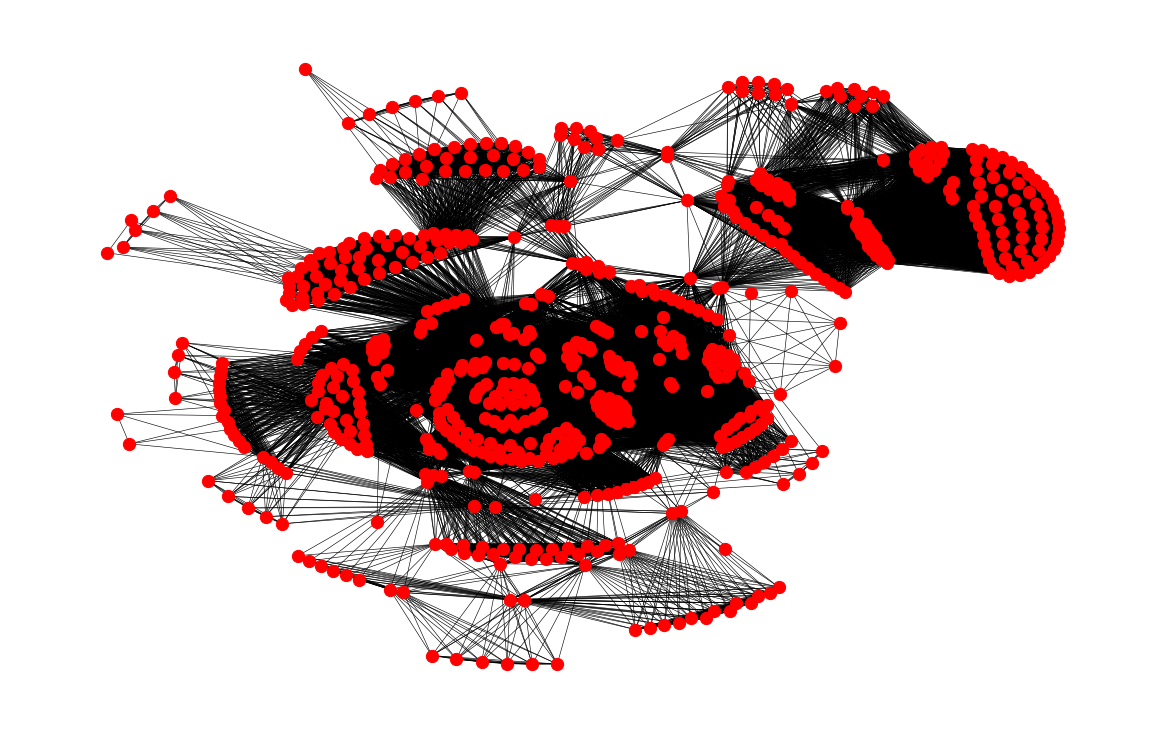

In [225]:
# draw network
plt.figure(figsize=(16, 10))
nx.draw_kamada_kawai(G, node_color="r", width=0.6, with_labels=False, node_size=150)
plt.show()

1. Preprocessing/Train-Test Split

In [ ]:
np.random.seed(0) # make sure train-test split is consistent between notebooks
adj_sparse = nx.to_scipy_sparse_matrix(G)

# Perform train-test split
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.1)
G_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

In [ ]:
# Inspect train/test split
print("Total nodes:", adj_sparse.shape[0])
print("Total edges:", int(adj_sparse.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
print("Training edges (negative):", len(train_edges_false))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 656
Total edges: 26317
Training edges (positive): 15791
Training edges (negative): 15791
Validation edges (positive): 2631
Validation edges (negative): 2631
Test edges (positive): 7895
Test edges (negative): 7895


2. Train node2vec (Learn Node Embeddings)

In [ ]:
import node2vec
from node2vec import Node2Vec
from gensim.models import Word2Vec

In [ ]:
# node2vec settings
# NOTE: When p = q = 1, this is equivalent to DeepWalk

P = 0.5 # Return hyperparameter
Q = 1 # In-out hyperparameter
WINDOW_SIZE = 10 # Context size for optimization
NUM_WALKS = 10 # Number of walks per source
WALK_LENGTH = 100 # Length of walk per source
DIMENSIONS = 128 # Embedding dimension
DIRECTED = False # Graph directed/undirected
WORKERS = 8 # Num. parallel workers
ITER = 3 # SGD epochs

In [ ]:
node2vec = Node2Vec(G_train, dimensions=DIMENSIONS, walk_length=WALK_LENGTH, num_walks=NUM_WALKS, workers=WORKERS, temp_folder="/mnt")
model = node2vec.fit(window=WINDOW_SIZE, min_count=1)

Computing transition probabilities:   0%|          | 0/656 [00:00<?, ?it/s]


Generating walks (CPU: 1):   0%|          | 0/2 [00:00<?, ?it/s]




Generating walks (CPU: 6):   0%|          | 0/1 [00:00<?, ?it/s]



Generating walks (CPU: 5):   0%|          | 0/1 [00:00<?, ?it/s]






Generating walks (CPU: 8):   0%|          | 0/1 [00:00<?, ?it/s]


Generating walks (CPU: 4):   0%|          | 0/1 [00:00<?, ?it/s]





Generating walks (CPU: 7):   0%|          | 0/1 [00:00<?, ?it/s]

Generating walks (CPU: 5): 100%|██████████| 1/1 [01:13<00:00, 73.89s/it]

Generating walks (CPU: 1): 100%|██████████| 2/2 [01:27<00:00, 43.74s/it]


In [ ]:
emb_mappings = model.wv

3. Create Edge Embeddings

In [ ]:
# Create node embeddings matrix (rows = nodes, columns = embedding features)
emb_list = []
for node_index in range(0, adj_sparse.shape[0]):
    node_str = str(node_index)
    node_emb = emb_mappings[node_str]
    emb_list.append(node_emb)
emb_matrix = np.vstack(emb_list)

In [ ]:
# Generate bootstrapped edge embeddings (as is done in node2vec paper)
# Edge embedding for (v1, v2) = hadamard product of node embeddings for v1, v2
def get_edge_embeddings(edge_list):
    embs = []
    for edge in edge_list:
        node1 = edge[0]
        node2 = edge[1]
        emb1 = emb_matrix[node1]
        emb2 = emb_matrix[node2]
        edge_emb = np.multiply(emb1, emb2)
        embs.append(edge_emb)
    embs = np.array(embs)
    return embs

In [ ]:
# Train-set edge embeddings
pos_train_edge_embs = get_edge_embeddings(train_edges)
neg_train_edge_embs = get_edge_embeddings(train_edges_false)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])

# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

# Val-set edge embeddings, labels
pos_val_edge_embs = get_edge_embeddings(val_edges)
neg_val_edge_embs = get_edge_embeddings(val_edges_false)
val_edge_embs = np.concatenate([pos_val_edge_embs, neg_val_edge_embs])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

# Test-set edge embeddings, labels
pos_test_edge_embs = get_edge_embeddings(test_edges)
neg_test_edge_embs = get_edge_embeddings(test_edges_false)
test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

# Create val-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

4. Vizualization

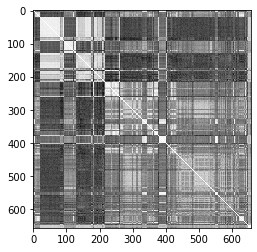

In [ ]:
distanceMatrix = cosine_distances(emb_matrix)
plt.imshow(distanceMatrix, cmap = 'Greys', interpolation = 'None')

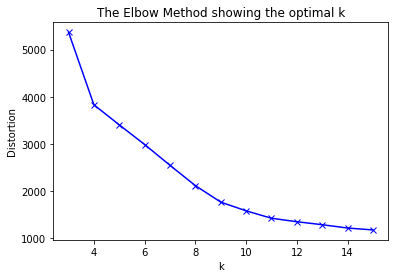

In [ ]:
distortions = []
K = range(3,16)
for k in K:
    k_cluster = KMeans(n_clusters=k, max_iter=500, random_state=656).fit(distanceMatrix)
    k_cluster.fit(distanceMatrix)
    distortions.append(k_cluster.inertia_)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

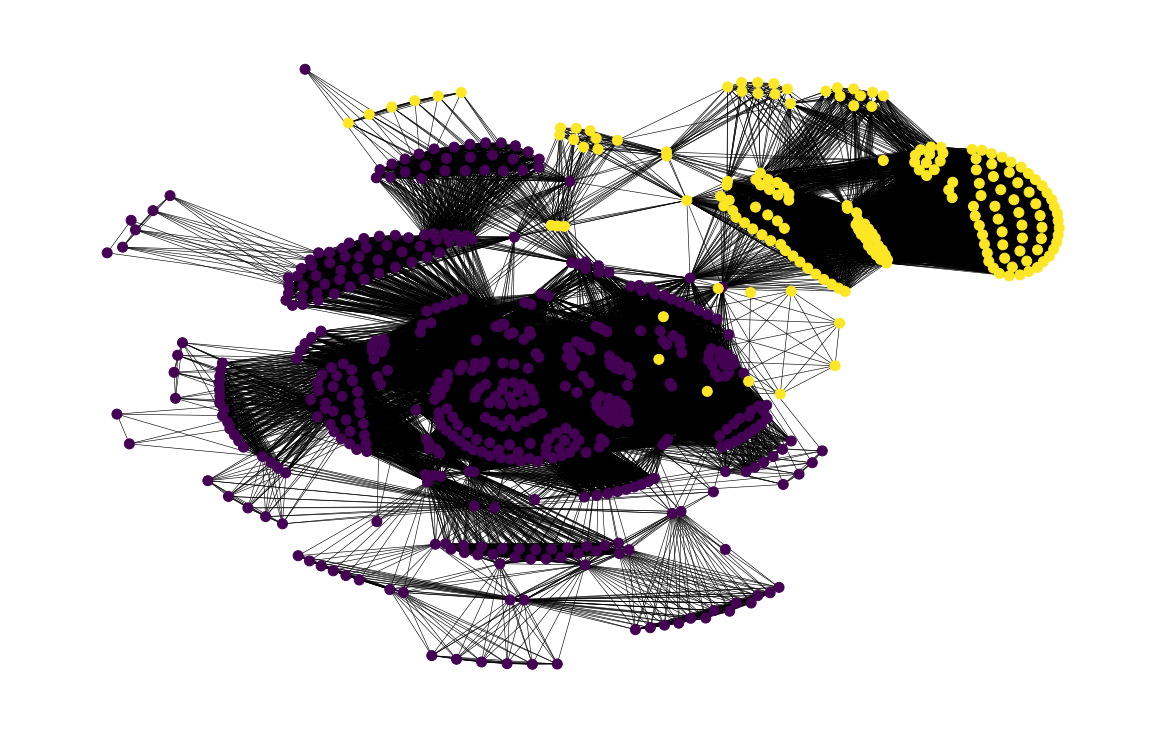

In [215]:
clusters = AgglomerativeClustering(n_clusters=2, affinity = 'precomputed', linkage='average').fit_predict(distanceMatrix)

plt.figure(figsize=(16, 10))
nx.draw_kamada_kawai(G, node_color=clusters, width=0.6, with_labels=False, node_size=100)

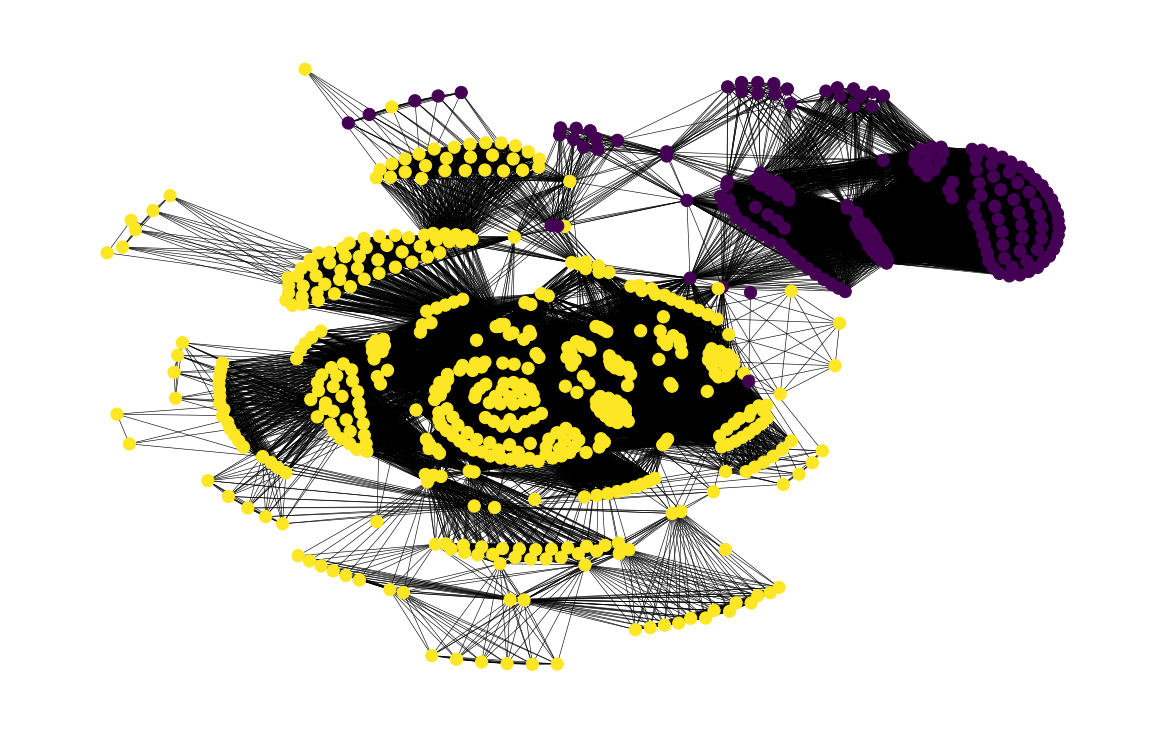

In [216]:
clusters = KMeans(n_clusters=2, init='k-means++', n_init=300, random_state=656).fit_predict(distanceMatrix)

plt.figure(figsize=(16, 10))
nx.draw_kamada_kawai(G, node_color=clusters, width=0.6, with_labels=False, node_size=150)

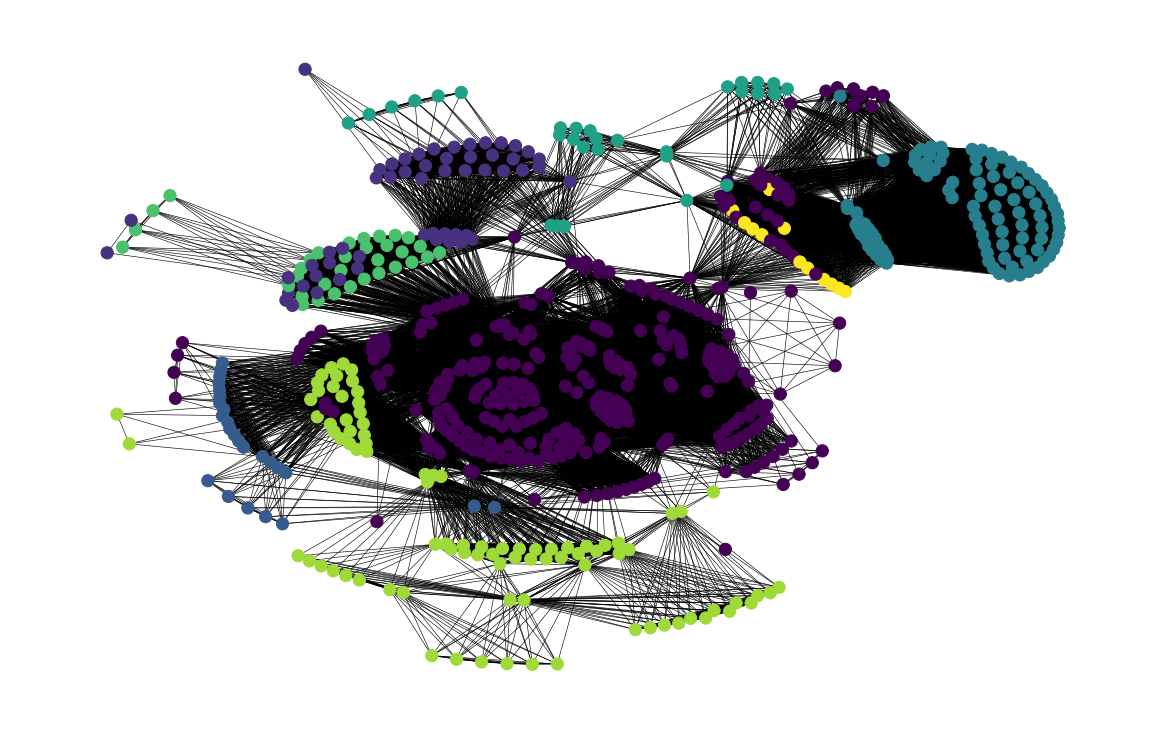

In [237]:
clusters = DBSCAN(eps=0.2, min_samples=10, metric = 'precomputed').fit_predict(distanceMatrix)
plt.figure(figsize=(16, 10))
sizes = [300 if clusters[i] >= 0 else 50 for i in range(len(clusters))]
nx.draw_kamada_kawai(G, node_color=clusters, node_size=150, width=0.6, with_labels=False)

5. Evaluate Edge Embeddings

In [226]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression
edge_classifier = LogisticRegression(random_state=0)
edge_classifier.fit(train_edge_embs, train_edge_labels)

LogisticRegression(random_state=0)

In [227]:
# Predicted edge scores: probability of being of class "1" (real edge)
val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
val_roc = roc_auc_score(val_edge_labels, val_preds)
val_ap = average_precision_score(val_edge_labels, val_preds)

In [228]:
# Predicted edge scores: probability of being of class "1" (real edge)
test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds)
test_ap = average_precision_score(test_edge_labels, test_preds)

In [229]:
print('node2vec Validation ROC score: ', str(val_roc))
print('node2vec Validation AP score: ', str(val_ap))
print('node2vec Test ROC score: ', str(test_roc))
print('node2vec Test AP score: ', str(test_ap))

node2vec Validation ROC score:  0.9701506509311182
node2vec Validation AP score:  0.9618194273973146
node2vec Test ROC score:  0.965203427987908
node2vec Test AP score:  0.9573532043308183
